# Functional Neural Network with Adaptive Bases

In this notewboook, we present a PyTorch implementation of the model proposed in "Deep Learning for Functional Data Analysis with Adaptive Basis Layers", ICML 2021.

Unlike many functional networks, AdaFNNs take the raw functional data as input and learn to apply parsimonious dimension reduction that focuses only on information relevant to the target rather than irrelevant variation in the input. This operation is done through a novel _Basis Layer_ that consists of _basis nodes_ implemented as micro networks. In addition, the inference and training can be done in an end-to-end manner without preprocessing the data.

# Implementing AdaFNNs

First, we provide the code for two building blocks, a layer normalization module and feedforward network module (with skipping connection). We start by import the necessary packages.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Layer Normalization

The layer normalization was introduced in [Layer Normalization](https://arxiv.org/abs/1607.06450). It is a transposition of Batch Normalization.

In [2]:
class LayerNorm(nn.Module):

    def __init__(self, d, eps=1e-6):
        super().__init__()
        # d is the normalization dimension
        self.d = d
        self.eps = eps
        self.alpha = nn.Parameter(torch.randn(d))
        self.beta = nn.Parameter(torch.randn(d))

    def forward(self, x):
        # x is a torch.Tensor
        # avg is the mean value of a layer
        avg = x.mean(dim=-1, keepdim=True)
        # std is the standard deviation of a layer (eps is added to prevent dividing by zero)
        std = x.std(dim=-1, keepdim=True) + self.eps
        return (x - avg) / std * self.alpha + self.beta

Next, we implement a feedforward network module.

In [3]:
class FeedForward(nn.Module):

    def __init__(self, in_d=1, hidden=[4,4,4], dropout=0.1, activation=F.relu):
        # in_d      : input dimension, integer
        # hidden    : hidden layer dimension, array of integers
        # dropout   : dropout probability, a float between 0.0 and 1.0
        # activation: activation function at each layer
        super().__init__()
        self.sigma = activation
        dim = [in_d] + hidden + [1]
        self.layers = nn.ModuleList([nn.Linear(dim[i-1], dim[i]) for i in range(1, len(dim))])
        self.ln = nn.ModuleList([LayerNorm(k) for k in hidden])
        self.dp = nn.ModuleList([nn.Dropout(dropout) for _ in range(len(hidden))])

    def forward(self, t):
        for i in range(len(self.layers)-1):
            t = self.layers[i](t)
            # skipping connection
            t = t + self.ln[i](t)
            t = self.sigma(t)
            # apply dropout
            t = self.dp[i](t)
        # linear activation at the last layer
        return self.layers[-1](t)

### Metric operations

To build an AdaFNN, we need three new operations: (1) $\langle f_1, f_2 \rangle$ (2) $\| f \|_2$ and (3) $\| f \|_1$. The last two can be established on the first one through:

$$ \| f\|_2 = \sqrt{ \langle f, f \rangle} $$
and
$$ \| f\|_1 = \langle 1, |f| \rangle .$$

Since the input is densely observed (equal spacing is not required), the inner product can be approximated by any numerical integration scheme. Here, we will use the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [4]:
def _inner_product(f1, f2, h):
    """
    f1 - (B, J) : B functions, observed at J time points,
    f2 - (B, J) : same as f1
    h  - (J-1,1): weights used in the trapezoidal rule
    pay attention to dimension
    <f1, f2> = sum (h/2) (f1(t{j}) + f2(t{j+1}))
    """
    prod = f1 * f2 # (B, J = len(h) + 1)
    return torch.matmul((prod[:, :-1] + prod[:, 1:]), h.unsqueeze(dim=-1))/2

Then $L_1$ and $L_2$ can be easily implememnted as:

In [5]:
def _l1(f, h):
    # f dimension : ( B bases, J )
    B, J = f.size()
    return _inner_product(torch.abs(f), torch.ones((B, J)), h)

In [6]:
def _l2(f, h):
    # f dimension : ( B bases, J )
    # output dimension - ( B bases, 1 )
    return torch.sqrt(_inner_product(f, f, h))

### AdaFNN

To prevent the original scale of basis nodes from dominating regularizers, they are normalized.

With these in hand, we are ready to present the AdaFNN implmentation.

In [7]:
class AdaFNN(nn.Module):

    def __init__(self, n_base=4, base_hidden=[64, 64, 64], grid=(0, 1),
                 sub_hidden=[128, 128, 128], dropout=0.1, lambda1=0.0, lambda2=0.0,
                 device=None):
        """
        n_base      : number of basis nodes, integer
        base_hidden : hidden layers used in each basis node, array of integers
        grid        : observation time grid, array of sorted floats including 0.0 and 1.0
        sub_hidden  : hidden layers in the subsequent network, array of integers
        dropout     : dropout probability
        lambda1     : penalty of L1 regularization, a positive real number
        lambda2     : penalty of L2 regularization, a positive real number
        device      : device for the training
        """
        super().__init__()
        self.n_base = n_base
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.device = device
        # grid should include both end points
        grid = np.array(grid)
        # send the time grid tensor to device
        self.t = torch.tensor(grid).to(device).float()
        self.h = torch.tensor(grid[1:] - grid[:-1]).to(device).float()
        # instantiate each basis node in the basis layer
        self.BL = nn.ModuleList([FeedForward(1, hidden=base_hidden, dropout=dropout, activation=F.selu)
                                 for _ in range(n_base)])
        # instantiate the subsequent network
        self.FF = FeedForward(n_base, sub_hidden, dropout)

    def forward(self, x):
        B, J = x.size()
        assert J == self.h.size()[0] + 1
        T = self.t.unsqueeze(dim=-1)
        # evaluate the current basis nodes at time grid
        self.bases = [basis(T).transpose(-1, -2) for basis in self.BL]
        """
        compute each basis node's L2 norm
        normalize basis nodes
        """
        l2_norm = _l2(torch.cat(self.bases, dim=0), self.h).detach()
        self.normalized_bases = [self.bases[i] / (l2_norm[i, 0] + 1e-6) for i in range(self.n_base)]
        # compute each score <basis_i, f>
        score = torch.cat([_inner_product(b.repeat((B, 1)), x, self.h) # (B, 1)
                           for b in self.bases], dim=-1) # score dim = (B, n_base)
        # take the tensor of scores into the subsequent network
        out = self.FF(score)
        return out

    def R1(self, l1_k):
        """
        L1 regularization
        l1_k : number of basis nodes to regularize, integer
        """
        if self.lambda1 == 0: return torch.zeros(1).to(self.device)
        # sample l1_k basis nodes to regularize
        selected = np.random.choice(self.n_base, min(l1_k, self.n_base), replace=False)
        selected_bases = torch.cat([self.normalized_bases[i] for i in selected], dim=0) # (k, J)
        return self.lambda1 * torch.mean(_l1(selected_bases, self.h))

    def R2(self, l2_pairs):
        """
        L2 regularization
        l2_pairs : number of pairs to regularize, integer
        """
        if self.lambda2 == 0 or self.n_base == 1: return torch.zeros(1).to(self.device)
        k = min(l2_pairs, self.n_base * (self.n_base - 1) // 2)
        f1, f2 = [None] * k, [None] * k
        for i in range(k):
            a, b = np.random.choice(self.n_base, 2, replace=False)
            f1[i], f2[i] = self.normalized_bases[a], self.normalized_bases[b]
        return self.lambda2 * torch.mean(torch.abs(_inner_product(torch.cat(f1, dim=0),
                                                                  torch.cat(f2, dim=0),
                                                                  self.h)))

#  Data

First, we import necessary dependencies.

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path

Next, we list configurations for each cases and implememnt functions for generating $X$ and $y$.

In [9]:
z1 = [20, 5, 5] + [1] * 47
z2 = [1] * 50
z2[0] = z2[2] = 5
z2[4] = z2[9] = 3
Z = [z1, z2, z2, [1] * 50]


def _phi(k):
    if k == 1: return lambda t: np.ones((len(t),))
    return lambda t : np.sqrt(2) * np.cos((k-1) * np.pi * t)


def _b1(t):
    return (4 - 16 * t) * (0 <= t) * (t <= 1/4)


def _b2(t):
    return (4 - 16 * np.abs(1/2 - t)) * (1/4 <= t) * (t <= 3/4)

In [10]:
X1 = pd.read_csv("data_windowedtrainw1.csv", header=None)



In [11]:
X2 = pd.read_csv("data_windowedtestw1.csv", header=None)



In [12]:
X2

,0,1,2,3,4,5,6,7
0,6247.00,6599.17,6509.61,6504.78,6489.77,6457.21,6301.61,6390.42
1,6599.17,6509.61,6504.78,6489.77,6457.21,6301.61,6390.42,6437.76
2,6509.61,6504.78,6489.77,6457.21,6301.61,6390.42,6437.76,6444.97
3,6504.78,6489.77,6457.21,6301.61,6390.42,6437.76,6444.97,6408.53
4,6489.77,6457.21,6301.61,6390.42,6437.76,6444.97,6408.53,5756.77
5,6457.21,6301.61,6390.42,6437.76,6444.97,6408.53,5756.77,5572.44
6,6301.61,6390.42,6437.76,6444.97,6408.53,5756.77,5572.44,4491.98
7,6390.42,6437.76,6444.97,6408.53,5756.77,5572.44,4491.98,4352.98
8,6437.76,6444.97,6408.53,5756.77,5572.44,4491.98,4352.98,3793.35
9,6444.97,6408.53,5756.77,5572.44,4491.98,4352.98,3793.35,4278.77


In [13]:
X1

,0,1,2,3,4,5,6,7
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
3502,6483.73,6573.62,6626.85,6247.00,6599.17,6509.61,6504.78,6489.77
3503,6573.62,6626.85,6247.00,6599.17,6509.61,6504.78,6489.77,6457.21
3504,6626.85,6247.00,6599.17,6509.61,6504.78,6489.77,6457.21,6301.61
3505,6247.00,6599.17,6509.61,6504.78,6489.77,6457.21,6301.61,6390.42


In [14]:
Y1 = pd.read_csv("targettrainw1.csv", header=None)

In [15]:
Y2 = pd.read_csv("targettestw1.csv", header=None)

In [16]:
Y1

,0
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
...,...
3502,6457.21
3503,6301.61
3504,6390.42
3505,6437.76


In [17]:
Y2

,0
0,6437.76
1,6444.97
2,6408.53
3,5756.77
4,5572.44
5,4491.98
6,4352.98
7,3793.35
8,4278.77
9,4140.60


In [18]:
T1 = pd.read_csv("numbersw.csv", header=None)

In [19]:
T1

,0,1,2,3,4,5,6,7
0,0.0,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0


The time grid doesn't have to be equally spaced. The model works as long as the time gap is small enough for numerical integration to work well.

In [20]:
def random_grid(d=0.02):
    """
    d : maximum time gap between two consecutive time points, float
    """
    grid = [0.0]
    while 1.0 - grid[-1] > d:
        grid.append(grid[-1] + np.random.uniform(0, d, 1).item())
    return grid + [1.0]

### Data Loader

This module reads the dataset from csv files and split it according to a pre-specific train/valid/test ratio. The dataset is standardized.

In [21]:
from sklearn.preprocessing import StandardScaler

class DataLoader1:

    def __init__(self, batch_size, X, Y, T, split=(8, 1, 1) ,random_seed=10294):
        """
        batch_size : batch size, integer
        X - (n, J) : pandas.DataFrame for observed functional data, n - subject number, J - number of time points
        Y - (n, 1) : pandas.DataFrame for response
        split      : train/valid/test split
        random_seed: random seed for training data re-shuffle
        """
        self.n, J = X.shape
        self.t = T.iloc[0, :].to_numpy()
        X, Y = X.values, Y.values

        # train/valid/test split
        self.batch_size = batch_size
        train_n = self.n // sum(split) * split[0]
        valid_n = self.n // sum(split) * split[1]
        
        X2 = pd.read_csv("data_windowedtestw1.csv", header=None)
        Y2 = pd.read_csv("targettestw1.csv", header=None)


        
        self.n1, J = X2.shape

        self.t = T.iloc[0, :].to_numpy()
        X2, Y2 = X2.values, Y2.values
        
        test_n = self.n1 // sum(split) * 10
        
        self.train_B = train_n // batch_size
        #self.valid_B = valid_n // batch_size
        self.test_B = test_n // 5

        

        # standardize dataset based on the training dataset
        self.X_standardizer = StandardScaler()
        #self.Y_standardizer = StandardScaler()

        # train/valid/test split
        #self.train_X = X[:(self.train_B * self.batch_size), :]
        #self.train_Y = Y[:(self.train_B * self.batch_size), :]
        self.train_X = X
        self.train_Y = Y
        #self.X_standardizer.fit(self.train_X)
        #self.Y_standardizer.fit(self.train_Y)
        #self.train_X = self.X_standardizer.transform(self.train_X)
        #self.train_Y = self.Y_standardizer.transform(self.train_Y)

        #self.valid_X = X[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        #self.valid_Y = Y[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        #self.valid_X = self.X_standardizer.transform(self.valid_X)
        #self.valid_Y = self.Y_standardizer.transform(self.valid_Y)

        self.test_X = X2
        self.test_Y = Y2
        #self.test_X = self.X_standardizer.transform(self.test_X)
        #self.test_Y = self.Y_standardizer.transform(self.test_Y)

        
    def shuffle(self):
        # re-shuffle the training dataset
        train_size = self.train_X.shape[0]
        new_order = list(range(train_size))
        np.random.shuffle(new_order)
        self.train_X = self.train_X[new_order, :]
        self.train_Y = self.train_Y[new_order, :]        
        

    def _batch_generator(self, X, Y, N):

        def generator_func():
            for i in range(1, N):
                x = X[((i - 1) * self.batch_size):((i) * self.batch_size), :]
                y = Y[((i - 1) * self.batch_size):((i) * self.batch_size), :]

                yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()
    def _batch_generator1(self, X, Y, N):

        def generator_func():
            x = X
            y = Y
            yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()
    
    def get_train_batch(self):
        return self._batch_generator(self.train_X, self.train_Y, self.train_B)

    #def get_valid_batch(self):
        #return self._batch_generator(self.valid_X, self.valid_Y, self.valid_B)

    def get_test_batch(self):
        return self._batch_generator1(self.test_X, self.test_Y, self.test_B)

# Training the model

First, we load necessary packages.

In [22]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.optim import Adam

A dataset will be generated if it is not present.

Here, we set the measurement error variance to be 1 and noise variance to be 0.2.

**Note**: in this example, we use a flexible time point gap (**not** equal spacing).

The dataset is loaded and split for training/validation/test.

In [23]:
batch_size = 400
split = (10, 0, 0)

In [24]:
grid = T1.iloc[0, :].to_list()
dataLoader = DataLoader1(batch_size,  X1, Y1, T1, split)

Prepare the model and other training configurations:

In [25]:
# set up CPU/GPU
device = torch.device("cpu")
# model configuration
"""
You can use a different model by modifing base_hidden, sub_hidden, n_base.
"""
base_hidden = [256,256,256,256]
sub_hidden = [1024,512,256,128]
n_base = 12
lambda1, l1_k = 0.0, 2
lambda2, l2_pairs = 0.0, 3
dropout = 0.1
save_model_every = 100
model = AdaFNN(n_base=n_base,
               base_hidden=base_hidden,
               grid=grid,
               sub_hidden=sub_hidden,
               dropout=dropout,
               lambda1=lambda1,
               lambda2=lambda2,
               device=device)
# send model to CPU/GPU
_ = model.to(device)

In [26]:
# training configuration
epoch = 15000
pred_loss_train_history = []
total_loss_train_history = []
loss_valid_history = []
# instantiate an optimizer
optimizer = Adam(model.parameters(), lr=3e-4)
# use MSE loss
compute_loss = torch.nn.MSELoss()
min_valid_loss = sys.maxsize

Create a folder to save checkpoints.

In [27]:
folder = "train/"
Path(folder).mkdir(parents=True, exist_ok=True)

Save and load models:

In [28]:
def save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer):
    checkpoint = {'n_base': n_base,
                  'base_hidden': base_hidden,
                  'grid': grid,
                  'sub_hidden': sub_hidden,
                  'dropout': dropout,
                  'lambda1' : lambda1,
                  'lambda2' : lambda2,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, folder + str(k) + '_' + 'checkpoint.pth')


def load_model(file_path, device):
    checkpoint = torch.load(file_path)
    model = AdaFNN(n_base=checkpoint['n_base'],
                   base_hidden=checkpoint['base_hidden'],
                   grid=checkpoint['grid'],
                   sub_hidden=checkpoint['sub_hidden'],
                   dropout=checkpoint['dropout'],
                   lambda1=checkpoint['lambda1'],
                   lambda2=checkpoint['lambda2'],
                   device=device)
    model.load_state_dict(checkpoint['state_dict'])
    _ = model.to(device)
    return model, checkpoint['grid']

Training procedure:

In [29]:
import math
for k in range(epoch):

    if k and k % save_model_every == 0:
        save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer)

    pred_loss_train = []
    total_loss_train = []
    loss_valid = []
    dataLoader.shuffle()
    # set model training state
    model.train()

    for i, (x, y) in enumerate(dataLoader.get_train_batch()):
        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss_pred = compute_loss(out, y)
        #loss = loss_pred + model.R1(l1_k) + model.R2(l2_pairs)
        loss = loss_pred 
        # record training loss history
        total_loss_train.append(loss.item())
        pred_loss_train.append(loss_pred.item())

        # update parameters using backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss_train_history.append(math.sqrt(np.mean(total_loss_train)))
    pred_loss_train_history.append(math.sqrt(np.mean(pred_loss_train)))



    if (k+1) % 50 == 0:
        print("epoch:", k+1, "\n",
              "prediction training loss = ", pred_loss_train_history[-1],
              )
        

epoch: 50 
 prediction training loss =  429.91984821924325
epoch: 100 
 prediction training loss =  442.54567459997037
epoch: 150 
 prediction training loss =  482.0974831493404
epoch: 200 
 prediction training loss =  414.1732257612749
epoch: 250 
 prediction training loss =  383.5170622717735
epoch: 300 
 prediction training loss =  354.5905523578266
epoch: 350 
 prediction training loss =  321.134401102449
epoch: 400 
 prediction training loss =  346.06721742056743
epoch: 450 
 prediction training loss =  398.7318807459648
epoch: 500 
 prediction training loss =  298.832690849806
epoch: 550 
 prediction training loss =  386.0591776089145
epoch: 600 
 prediction training loss =  341.43651365538346
epoch: 650 
 prediction training loss =  396.53430539758205
epoch: 700 
 prediction training loss =  304.46541264977867
epoch: 750 
 prediction training loss =  337.50152777431987
epoch: 800 
 prediction training loss =  302.40963821564003
epoch: 850 
 prediction training loss =  450.115739

epoch: 6850 
 prediction training loss =  245.88947048710438
epoch: 6900 
 prediction training loss =  285.10665297644067
epoch: 7000 
 prediction training loss =  247.78982343103226
epoch: 7100 
 prediction training loss =  255.72993501969725
epoch: 7200 
 prediction training loss =  285.9649303782721
epoch: 7250 
 prediction training loss =  257.99196567466703
epoch: 7300 
 prediction training loss =  276.75632231615646
epoch: 7350 
 prediction training loss =  293.4038452478938
epoch: 7450 
 prediction training loss =  251.4556694191557
epoch: 7550 
 prediction training loss =  260.8913004439233
epoch: 7650 
 prediction training loss =  302.5890576918165
epoch: 7700 
 prediction training loss =  271.921450260194
epoch: 7750 
 prediction training loss =  241.5617053211841
epoch: 7800 
 prediction training loss =  262.9487745468959
epoch: 7850 
 prediction training loss =  277.21730190895113
epoch: 7900 
 prediction training loss =  254.53099047386576
epoch: 7950 
 prediction training

epoch: 14150 
 prediction training loss =  225.65656746421573
epoch: 14200 
 prediction training loss =  265.7099496514009
epoch: 14250 
 prediction training loss =  250.94702103446343
epoch: 14300 
 prediction training loss =  263.30647584747
epoch: 14350 
 prediction training loss =  236.21135360398867
epoch: 14400 
 prediction training loss =  242.95410928558093
epoch: 14450 
 prediction training loss =  248.06627982309053
epoch: 14500 
 prediction training loss =  267.6292411420802
epoch: 14550 
 prediction training loss =  236.8476213917475
epoch: 14650 
 prediction training loss =  238.42934946750998
epoch: 14700 
 prediction training loss =  236.47587699760354
epoch: 14750 
 prediction training loss =  239.4570728379992
epoch: 14800 
 prediction training loss =  254.93306413154806
epoch: 14850 
 prediction training loss =  271.3313154737146
epoch: 14900 
 prediction training loss =  217.57437857443963
epoch: 14950 
 prediction training loss =  214.9784412208167
epoch: 15000 
 pr

Please note that the validation error was computed after a training epoch was complete. So the validation error is generally smaller than the training error.

Make a loss plot after training finishes.

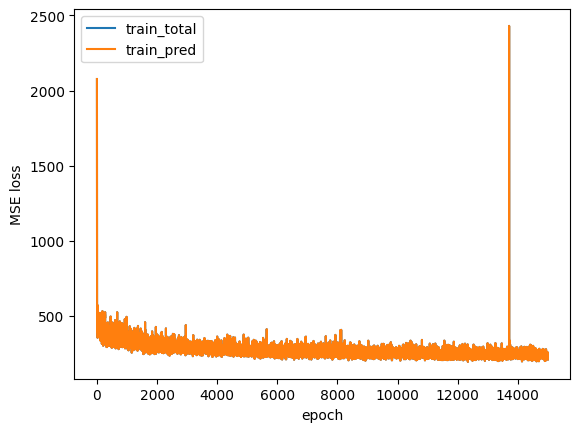

In [30]:
plt.plot(list(range(1, epoch+1)), total_loss_train_history, label='train_total')
plt.plot(list(range(1, epoch+1)), pred_loss_train_history, label='train_pred')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
# plt.savefig('loss_plot.png')
# plt.close()



After training, to make predictions, we can load the best model and run it on the (test) dataset.

In [31]:
def make_prediction(dataLoader, device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    # load the best model
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)

    loss_test  = []
    y_pred = []
    oy=[]

    with torch.no_grad():
        model.eval()
        """
        Get the performance of the best train model on test dataset
        """
        for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            print(test_y)
            oy.extend(y.cpu().numpy().tolist())
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            loss_test.append(test_loss.item())
    """
    Compute the MSE of the test dataset
    """
    timestamp = np.array([i for i in range(len(oy))])
    #y = dataLoader.Y_standardizer.inverse_transform(oy)
    #test_y = dataLoader.Y_standardizer.inverse_transform(y_pred)
    print(oy)
    print(y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(timestamp, oy, label='Actual Labels (y)', color='blue', linestyle='-')
    plt.xlabel('Timestamp')
    plt.ylabel('Actual Labels (y)')
    # Create a line plot for test_y
    plt.plot(timestamp, y_pred, label='Predicted Labels (test_y)', color='red', linestyle='--')
    plt.ylabel('Predicted Labels (test_y)')
    # Add a legend
    plt.legend()
    # Set the title
    plt.title('Actual vs. Predicted Labels Over Time')
    # Display the grid
    plt.grid(True)
    # Show the plot
    plt.show()


    print("test accuracy MSE :", np.mean(loss_test))

    """
    return the predicted y values by re-scaling the model output
    """

    #return dataLoader.Y_standardizer.inverse_transform(y_pred)
    return y_pred


In [32]:
for x, y in dataLoader.get_test_batch():
        x, y = x.to(device), y.to(device)
        test_y = model.forward(x)
        print(test_y)

tensor([[6455.3926],
        [5959.0137],
        [5839.6753],
        [6470.7656],
        [5830.6440],
        [5145.1548],
        [4821.5293],
        [4632.8042],
        [4156.3672],
        [4580.6172],
        [3497.3403],
        [3743.0305],
        [2962.3564],
        [3485.4851],
        [3352.1423],
        [3401.6763],
        [3271.2908],
        [4185.8481],
        [3800.6016],
        [3647.0723],
        [4061.6602],
        [3692.4658],
        [3979.6218],
        [3836.9639],
        [3437.8713],
        [3728.0942],
        [3759.4492],
        [3695.4758],
        [3703.2642],
        [3206.0903],
        [3426.5771],
        [3490.4583],
        [3390.3589],
        [3410.1733],
        [3505.3330],
        [3713.1777],
        [3937.2908],
        [3892.0312],
        [3876.2800],
        [3932.9365],
        [4125.9028],
        [3605.3691],
        [4006.4619],
        [3961.5107],
        [3870.8633],
        [4121.7300],
        [4033.6387],
        [3826

tensor([[6324.3687],
        [6412.2119],
        [6664.4248],
        [6644.2461],
        [5932.2227],
        [5323.0410],
        [4510.3882],
        [4821.7090],
        [4128.4023],
        [4865.0781],
        [3713.5488],
        [3213.1855],
        [3664.6396],
        [3252.1167],
        [3417.5039],
        [3464.9871],
        [4247.8115],
        [4269.7314],
        [3757.8213],
        [3839.0425],
        [3864.0471],
        [4063.9893],
        [4050.0295],
        [3437.8755],
        [3639.4905],
        [3282.2139],
        [3767.9756],
        [3438.8838],
        [3840.4099],
        [3548.3066],
        [3687.1782],
        [3270.2251],
        [3205.3984],
        [3402.8005],
        [3826.9666],
        [3388.9661],
        [3986.0303],
        [4070.4790],
        [3169.1516],
        [3471.7571],
        [3752.7729],
        [3595.2561],
        [3959.7563],
        [4307.7925],
        [3818.8438],
        [4117.4985],
        [3447.5166],
        [3797

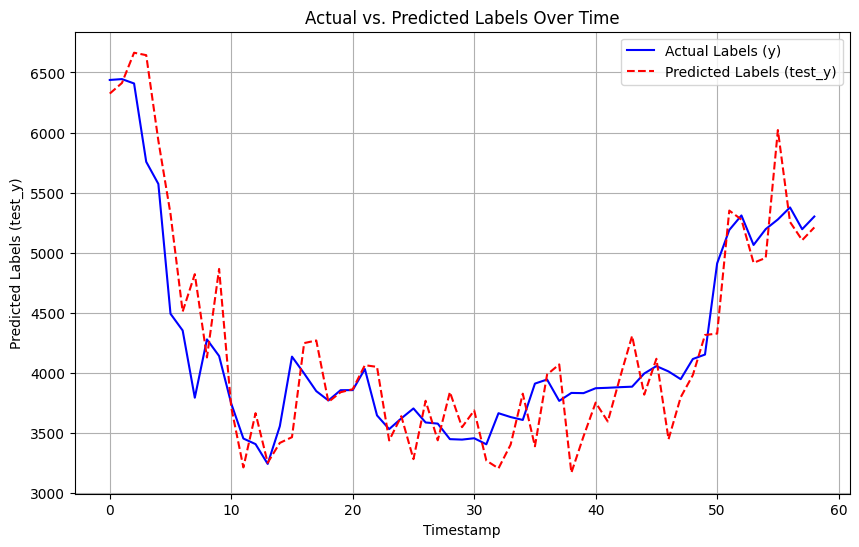

test accuracy MSE : 362.88369779448624
test accuracy MAPE : 3.9930377155542374


In [33]:
loss_test  = []
y_pred = []
oy=[]
loss_mape  = []
from ignite.contrib.metrics.regression import *
from ignite.engine import *
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)
metric = MedianAbsolutePercentageError()
metric.attach(default_evaluator, 'mape')
for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            print(test_y)
            oy.extend(y.cpu().numpy().tolist())
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            state = default_evaluator.run([[test_y, y]])
            loss_mape.append(state.metrics['mape'])
            loss_test.append(test_loss.item())
timestamp = np.array([i for i in range(len(oy))])
print(oy)
print(y_pred)
plt.figure(figsize=(10, 6))
plt.plot(timestamp, oy, label='Actual Labels (y)', color='blue', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Actual Labels (y)')
# Create a line plot for test_y
plt.plot(timestamp, y_pred, label='Predicted Labels (test_y)', color='red', linestyle='--')
plt.ylabel('Predicted Labels (test_y)')
# Add a legend
plt.legend()
# Set the title
plt.title('Actual vs. Predicted Labels Over Time')
# Display the grid
plt.grid(True)
# Show the plot
plt.show()


print("test accuracy MSE :", math.sqrt(np.mean(loss_test)))
print("test accuracy MAPE :", np.mean(loss_mape))

tensor([[6881.5400],
        [6718.1543],
        [6142.3887],
        [6450.6406],
        [5853.1855],
        [5389.6401],
        [4808.3032],
        [4521.7002],
        [4656.2148],
        [4668.2363],
        [3650.8127],
        [3692.8140],
        [3540.9775],
        [3399.4233],
        [3233.5850],
        [3512.0625],
        [3853.8789],
        [3982.8799],
        [4024.0186],
        [3769.2708],
        [3956.0605],
        [3993.9531],
        [4032.2922],
        [3836.4546],
        [3444.1064],
        [3545.3052],
        [4008.8191],
        [3435.9216],
        [3258.5354],
        [3614.0403],
        [3386.9832],
        [3180.8755],
        [3524.9307],
        [4111.1782],
        [3601.5566],
        [3759.9822],
        [4197.2422],
        [3749.2871],
        [4024.6829],
        [4179.4526],
        [3872.0444],
        [3896.5186],
        [4056.2393],
        [3961.9072],
        [4161.7930],
        [4129.1973],
        [3910.2698],
        [3748

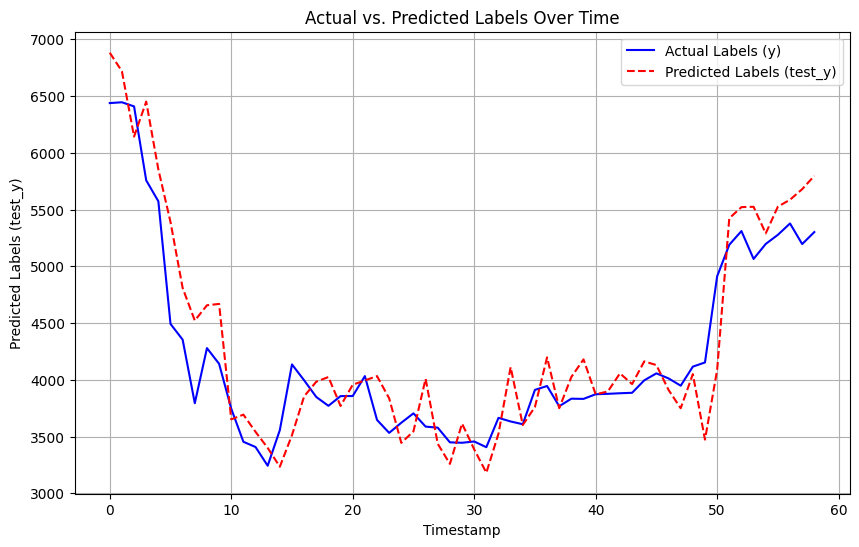

test accuracy MSE : 341.2302878922092


In [34]:
loss_test  = []
y_pred = []
oy=[]
for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            print(test_y)
            oy.extend(y.cpu().numpy().tolist())
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            loss_test.append(test_loss.item())
timestamp = np.array([i for i in range(len(oy))])
print(oy)
print(y_pred)
plt.figure(figsize=(10, 6))
plt.plot(timestamp, oy, label='Actual Labels (y)', color='blue', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Actual Labels (y)')
# Create a line plot for test_y
plt.plot(timestamp, y_pred, label='Predicted Labels (test_y)', color='red', linestyle='--')
plt.ylabel('Predicted Labels (test_y)')
# Add a legend
plt.legend()
# Set the title
plt.title('Actual vs. Predicted Labels Over Time')
# Display the grid
plt.grid(True)
# Show the plot
plt.show()


print("test accuracy MSE :", math.sqrt(np.mean(loss_test)))

In [35]:
y_pred = make_prediction(dataLoader)

AssertionError: 

In [ ]:
y_pred

We can plot the learned bases.

In [ ]:
def plot_bases( device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)

    bases = []

    loss_test  = []

    with torch.no_grad():
        model.eval()

        for i, basis in enumerate(model.BL):
            T = T.unsqueeze(dim=-1)
            y = np.squeeze(basis(T).squeeze(dim=-1).detach().cpu().numpy())
            y_sq = y ** 2
            l2_norm = np.sqrt(np.sum((y_sq[:-1] + y_sq[1:]) * (t[1:] - t[:-1])) / 2)
            bases.append(y / l2_norm)

    B = len(bases)
    fig, axs = plt.subplots(1, B)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i in range(B):
        axs[i].plot(t, bases[i], linewidth=3.5, label="basis"+str(i+1))
        axs[i].legend()

    return bases


In [ ]:
bases = plot_bases()

Even when both measurement error and noise were present, using roughly 60% of the dataset, the model successfully captured the important features of the true signal $\phi_5$.

To better understand the learned bases, we can also plot a linear combination of them and see what it looks compared to the true one.

In [ ]:
def plot(t, y, color, label):
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(t, y, linewidth=3.5, color=color, label=label)
    plt.legend()

The coefficients of learned bases can vary in different experiments (see Theorem 1 and Remark 1 in the paper).

In [ ]:
np_b = [np.array(b) for b in bases]
lin = np_b[0] + 0.4 * np_b[1]
plot(grid, lin, "orangered", "learned basis1 + 0.4 * basis2")

The true signal $\phi_5$ in Case 3 is drawn below. We can see that two bases learned the truth successfully.

In [ ]:

phi5 = _phi(5)
plot(grid, phi5(np.array(grid)), "green", "true phi5")